# Running VQE simulation

In [1]:
!pip install ' qiskit-nature[pyscf]'
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pylab

from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit.circuit.library import TwoLocal
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto3g')

es_problem = ElectronicStructureProblem(driver)
second_q_ops = es_problem.second_q_ops()
main_op = second_q_ops[0]
num_particles = (es_problem.molecule_data_transformed.num_alpha,
                 es_problem.molecule_data_transformed.num_beta)
num_spin_orbitals = 2 * es_problem.molecule_data.num_molecular_orbitals

# mapper = JordanWignerMapper()
mapper = ParityMapper()

converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)
H2_op = converter.convert(main_op, num_particles=num_particles)
print("Qubit Hamiltonian:\n", H2_op)


Qubit Hamiltonian:
 0.18093119978423142 * XX
- 1.05237324577286 * II
- 0.39793742484317907 * ZI
+ 0.397937424843179 * IZ
- 0.011280104256235324 * ZZ


Since the above problem is still easily tractable classically we can use NumPyMinimumEigensolver to compute a reference value for the solution. We can now plot the difference from the resultant exact solution as the energy converges with VQE towards the minimum value which should be that exact classical solution.

In [3]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f'Reference value (exact energy): {ref_value:.5f}')

Reference value (exact energy): -1.85728


In [5]:
from qiskit_nature.circuit.library import HartreeFock, UCC
num_spin_orbitals = 2 * es_problem.molecule_data.num_molecular_orbitals

init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
ansatz_ucc = UCC(num_spin_orbitals=num_spin_orbitals, num_particles=num_particles, qubit_converter=converter,
                 excitations='sd', initial_state=init_state)
print("Number of parameters in UCC ansatz:", len(ansatz_ucc.parameters))
print("Depth of UCC ansatz:", ansatz_ucc.depth())
print(ansatz_ucc.decompose())

Number of parameters in UCC ansatz: 3
Depth of UCC ansatz: 1
     ┌───┐┌────────────────────────┐┌────────────────────────┐»
q_0: ┤ X ├┤0                       ├┤0                       ├»
     └───┘│  exp(-it IY)(1.0*t[0]) ││  exp(-it YI)(1.0*t[1]) │»
q_1: ─────┤1                       ├┤1                       ├»
          └────────────────────────┘└────────────────────────┘»
«     ┌───────────────────────────────┐
«q_0: ┤0                              ├
«     │  exp(-it (XY + YX))(1.0*t[2]) │
«q_1: ┤1                              ├
«     └───────────────────────────────┘


In [6]:
ansatz_he = TwoLocal(2, rotation_blocks='ry', entanglement_blocks='cz')
print("HE circuit\n", ansatz_he.decompose())
print("Number of parameters in HE ansatz:", len(ansatz_he.parameters))
print("Depth of HE ansatz:", ansatz_he.depth())

HE circuit
      ┌──────────┐   ┌──────────┐   ┌──────────┐   ┌──────────┐
q_0: ┤ Ry(θ[0]) ├─■─┤ Ry(θ[2]) ├─■─┤ Ry(θ[4]) ├─■─┤ Ry(θ[6]) ├
     ├──────────┤ │ ├──────────┤ │ ├──────────┤ │ ├──────────┤
q_1: ┤ Ry(θ[1]) ├─■─┤ Ry(θ[3]) ├─■─┤ Ry(θ[5]) ├─■─┤ Ry(θ[7]) ├
     └──────────┘   └──────────┘   └──────────┘   └──────────┘
Number of parameters in HE ansatz: 8
Depth of HE ansatz: 1


Running VQE using hardware efficient ansatz

In [7]:
vqe = VQE(ansatz_he, L_BFGS_B(),
          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print('\rOptimization complete      ');
print(result)

Optimization complete      
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 90,
    'eigenstate': array([ 5.87438698e-07+0.j, -9.93760360e-01+0.j,  1.11536299e-01+0.j,
        8.93495565e-07+0.j]),
    'eigenvalue': (-1.8572750302010657+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -2.9757290167292703,
                              ParameterVectorElement(θ[4]): 0.9612919780696034,
                              ParameterVectorElement(θ[5]): 1.4231975688691005,
                              ParameterVectorElement(θ[6]): -2.4816254846688737,
                              ParameterVectorElement(θ[3]): -4.412209851667608,
                              ParameterVectorElement(θ[2]): -4.54317639485173,
                              ParameterVectorElement(θ[0]): 4.343542453038456,
                              ParameterVectorElement(θ[1]): -5.89890413822143},
    'optimal_point': array([ 4.34354245, -5.89890414, -4.54317639, -4.41220985,  0.96129198,
        

Running VQE using UCC ansatz

In [8]:
vqe = VQE(ansatz_ucc, L_BFGS_B(),
          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print('\rOptimization complete      ');
print(result)

Optimization complete      
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 20,
    'eigenstate': array([-1.23007590e-08-2.77555756e-17j,  9.93760408e-01-6.99663259e-16j,
       -1.11535873e-01+3.92523124e-17j, -1.17398120e-09-1.66533454e-16j]),
    'eigenvalue': (-1.857275030202371+0j),
    'optimal_parameters': {   ParameterVectorElement(t[2]): 0.11176843277065636,
                              ParameterVectorElement(t[1]): 1.1739814224774008e-09,
                              ParameterVectorElement(t[0]): 1.2300759190043976e-08},
    'optimal_point': array([1.23007592e-08, 1.17398142e-09, 1.11768433e-01]),
    'optimal_value': -1.857275030202371,
    'optimizer_evals': None,
    'optimizer_time': 0.05070328712463379}


# Monitoring VQE convergence

Variational algorithms in Qiskit, like [VQE](https://qiskit.org/documentation/stubs/qiskit.algorithms.VQE.html) and [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.QAOA.html), provide the option for a user to give a callback method that can be used to monitor optimization progress as the algorithm runs and converges to the minimum. The callback is invoked for each functional evaluation by the optimizer and provides the current optimizer value, evaluation count, current optimizer parameters etc. Note that, depending on the specific optimizer this may not be each iteration (step) of the optimizer, so for example if the optimizer is calling the cost function to compute a finite difference based gradient this will be visible via the callback.

We will show the callback usage below over a set of optimizers for comparison. The minimum energy of the H2 Hamiltonian can be found quite easily so we are able to set maxiters to a small value

In [23]:
# HE ansatz
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts_he = np.empty([len(optimizers)], dtype=object)
converge_vals_he = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50

    counts_he = []
    values_he = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts_he.append(eval_count)
        values_he.append(mean)
  
    vqe = VQE(ansatz_he, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result_he = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts_he[i] = np.asarray(counts_he)
    converge_vals_he[i] = np.asarray(values_he)
print('\rOptimization complete      ');
# print(result_he)

Optimization complete      


Now from the callback data we stored we can plot the energy value at each objective function call each optimizer makes. An optimizer using a finite difference method for computing gradient has that characteristic step like plot where for a number of evaluations it is computing the value for close by points to establish a gradient (the close by points having very similar values whose difference cannot be seen on the scale of the graph here).

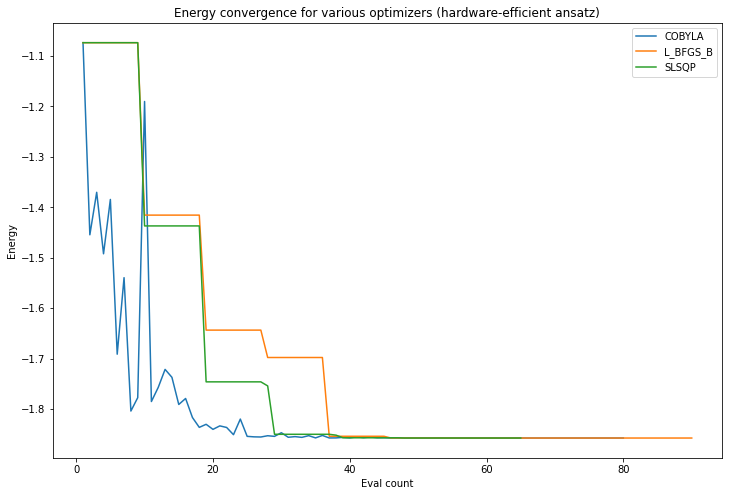

In [24]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts_he[i], converge_vals_he[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers (hardware-efficient ansatz)')
pylab.legend(loc='upper right');

In [25]:
# UCC ansatz
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_cnts_ucc = np.empty([len(optimizers)], dtype=object)
converge_vals_ucc = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
    algorithm_globals.random_seed = 50

    counts_ucc = []
    values_ucc = []
    def store_intermediate_result(eval_count, parameters, mean, std):
        counts_ucc.append(eval_count)
        values_ucc.append(mean)
  
    vqe = VQE(ansatz_ucc, optimizer, callback=store_intermediate_result,
              quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
    result_ucc = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_cnts_ucc[i] = np.asarray(counts_ucc)
    converge_vals_ucc[i] = np.asarray(values_ucc)
print('\rOptimization complete      ');

Optimization complete      


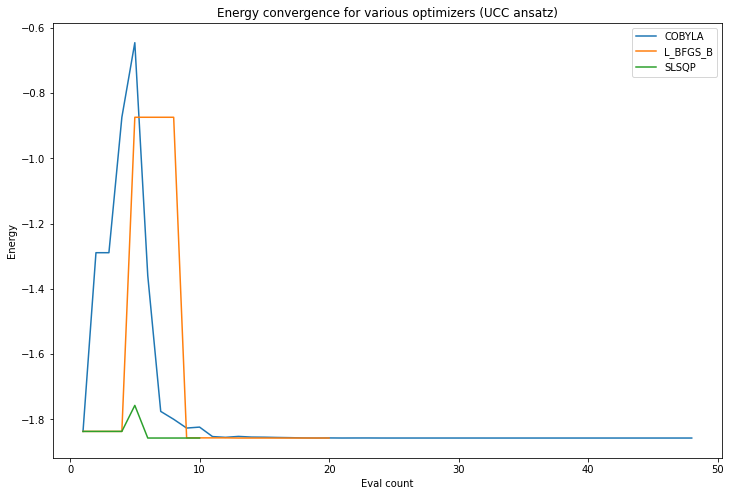

In [26]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts_ucc[i], converge_vals_ucc[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers (UCC ansatz)')
pylab.legend(loc='upper right');

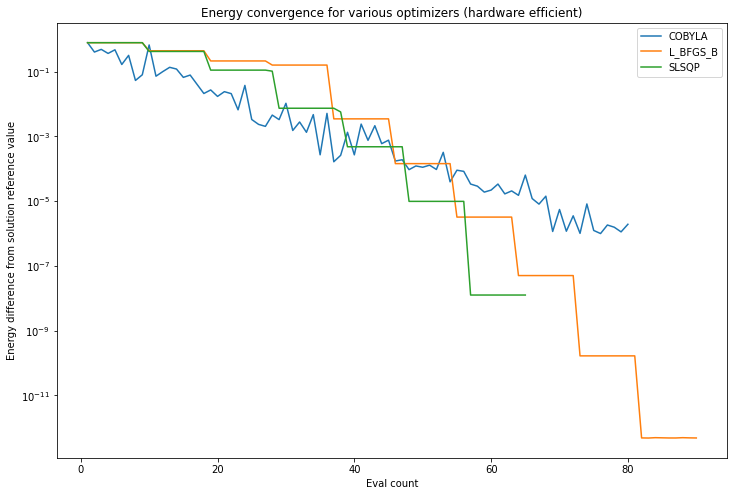

In [27]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts_he[i], abs(ref_value - converge_vals_he[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value')
pylab.title('Energy convergence for various optimizers (hardware efficient)')
pylab.yscale('log')
pylab.legend(loc='upper right');

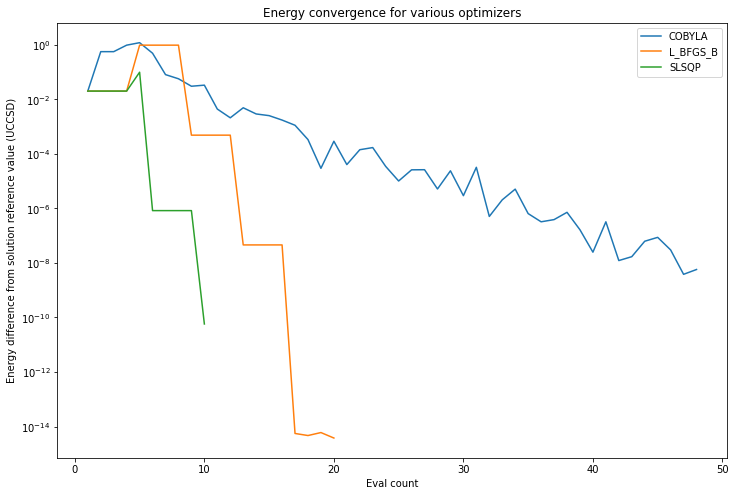

In [13]:
pylab.rcParams['figure.figsize'] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts_ucc[i], abs(ref_value - converge_vals_ucc[i]), label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy difference from solution reference value (UCCSD)')
pylab.title('Energy convergence for various optimizers')
pylab.yscale('log')
pylab.legend(loc='upper right');

## Using Gradient framework

Qiskit now has a Gradient framework as part of the Opflow capability. With the gradient computed for the optimizer we now see just the optimization steps themselves.

In [14]:
from qiskit.opflow.gradients import Gradient

algorithm_globals.random_seed = 50
ansatz = ansatz_ucc

optimizer = SLSQP(maxiter=60)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
          gradient=Gradient(),
          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f'Value using Gradient: {result.eigenvalue.real:.5f}')
print(counts, values)

Value using Gradient: -1.85728
[1, 2, 3, 4] [-1.8369679912029824, -1.7572866355398828, -1.8572741956404522, -1.8572750301445673]


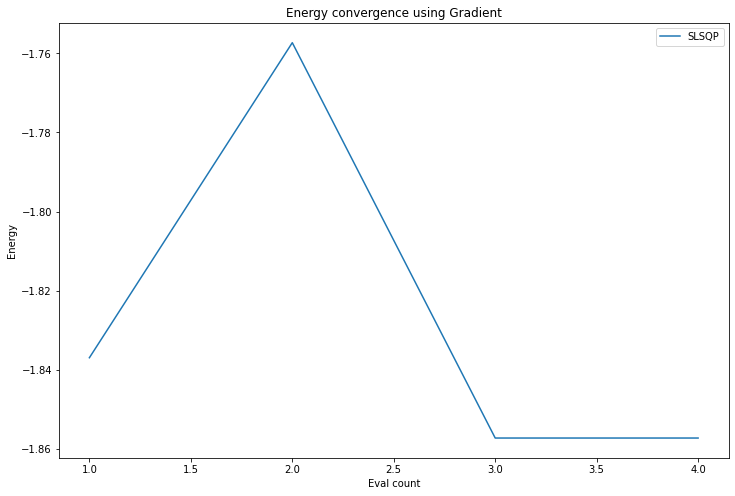

In [15]:
pylab.rcParams['figure.figsize'] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence using Gradient')
pylab.legend(loc='upper right');

In [18]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright
print("This code has been modified from the original version by Dmitry A. Fedorov")

This code has been modified from the original version by Dmitry A. Fedorov
